# Part 5: IV Measurements

This is the fith introductory overview of programming the Aspect Device Engine Python API.  
This document is available as pdf and interactive jupyter notebook.
The introduction includes the following objectives:
- Performing IV sweeps
- Working with autoranging in IV-sweeps

Please note: This chapter shows how to perform simple IV sweeps in software.  
For more advanced IV sweeps, see the next chapter ‘List Sweeps’. 

---

In [19]:
from aspectdeviceengine.enginecore import IdSmuService, IdSmuServiceRunner, IdSmuBoardModel, MeasurementMode, FunctionGeneratorType, generate_function_generator_data, CurrentRange
from aspectdeviceengine.enginecore import IdSmuBoardModel, ListSweepChannelConfiguration, ListSweep
import plotly.graph_objects as go
import numpy as np
srunner = IdSmuServiceRunner()

A few preparatory measures, nothing new here:

In [20]:
# Inintialization and preparation:
mbX1 : IdSmuBoardModel = srunner.get_idsmu_service().get_first_board()
print(mbX1.is_board_initialized())
device_id = "M1.S1"
channel1_id = f'{device_id}.C1'
channel2_id = f'{device_id}.C2'
channel_list = [channel1_id, channel2_id]

mbX1.set_voltages(1, channel_list)
mbX1.set_enable_channels(True,channel_list )
mbX1.set_measurement_modes(MeasurementMode.isense, channel_list)
mbX1.set_current_ranges(CurrentRange.Range_2mA_SMU, channel_list)

True


We define a simple helper function that can perform a software sweep.  
It returns the force values, the measured values and the current range for each step:

In [21]:
def sw_sweep(start, stop, step):
    force_values = np.arange(start,stop+step, step)
    ch1_results = np.zeros(len(force_values))
    ch2_results = np.zeros(len(force_values))
    ch1_ranges = []
    ch2_ranges = []
    for i, voltage in enumerate(force_values):
        mbX1.set_voltages(voltage, channel_list)
        measresults = mbX1.measure_channels(wait_for_result=False, sample_count=1, repetitions=1, channel_names=channel_list)
        measresult0 = mbX1.get_measurement_results_for_channel(channel1_id)
        ch1_ranges.append(mbX1.idSmu2Modules['M1.S1'].smu.channels[channel1_id].current_range.name)
        ch2_ranges.append(mbX1.idSmu2Modules['M1.S1'].smu.channels[channel2_id].current_range.name)
        ch1_results[i] = measresult0[channel1_id][0]
        ch2_results[i] = measresult0[channel2_id][0]
    return (force_values, ch1_results, ch2_results, ch1_ranges,ch2_ranges)

### Autoranging in manual IV sweeps
The first step is to perform the sweep with autoranging deactivated. 
The respective current range is then output for each step.

In [22]:
mbX1.set_current_ranges(CurrentRange.Range_200uA_SMU, channel_list)
mbX1.enable_autorange(False, ['M1.S1.C1'])
mbX1.set_voltages(1, channel_list)
sweep_without_autorange = sw_sweep(1,4, 0.2)
print(sweep_without_autorange[3])

['Range_200uA', 'Range_200uA', 'Range_200uA', 'Range_200uA', 'Range_200uA', 'Range_200uA', 'Range_200uA', 'Range_200uA', 'Range_200uA', 'Range_200uA', 'Range_200uA', 'Range_200uA', 'Range_200uA', 'Range_200uA', 'Range_200uA', 'Range_200uA']


Autoranging is performed for both channels using the `enable_autorange()` method:

In [23]:
mbX1.enable_autorange(True, channel_list)
#Alternatively, autoranging can also be queried or set via the properties/setter of a channel
print(mbX1.idSmu2Modules['M1.S1'].smu.channels[channel1_id].autorange)
sweep_with_autorange = sw_sweep(1,4, 0.2)
print(sweep_with_autorange[4])

True
['Range_2mA', 'Range_5uA', 'Range_5uA', 'Range_5uA', 'Range_5uA', 'Range_5uA', 'Range_5uA', 'Range_5uA', 'Range_70mA', 'Range_5uA', 'Range_70mA', 'Range_5uA', 'Range_70mA', 'Range_5uA', 'Range_70mA', 'Range_5uA']


### Plotting the results
The following plots show the difference between the sweep with and without autorange. 
With a fixed value of 200uA, the current curve saturates at approximately this value.  
With an autorange set, the better resolution at low currents becomes clear. 
The curve does not saturate and reaches around 500uA. The plots are annotated with the current ranges:  
*(Note: the enum prefixes 'Range_' are removed for better readability)*

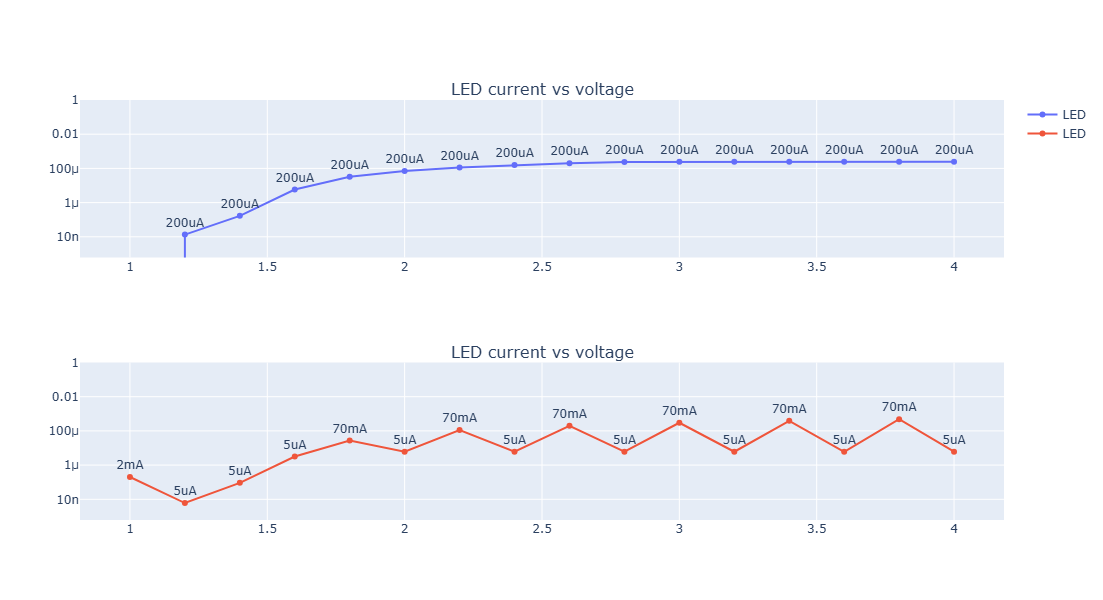

In [24]:
from plotly.subplots import make_subplots
def create_fig():  
    fig = make_subplots(rows=2, cols=1,  subplot_titles=("LED current vs voltage", "LED current vs voltage"))
    fig.add_trace(go.Scatter(x=sweep_without_autorange[0], y=sweep_without_autorange[1],
                        mode='lines+markers+text',
                        text = [s.replace("Range_", "") for s in sweep_without_autorange[3]],
                        textposition="top center",
                        name='LED'),  row=1, col=1)
    fig.add_trace(go.Scatter(x=sweep_with_autorange[0], y=sweep_with_autorange[1],
                        mode='lines+markers+text',
                        text = [s.replace("Range_", "") for s in sweep_with_autorange[3]],
                        textposition="top center",
                        name='LED'),  row=2, col=1)
    fig.update_yaxes(type="log", range=[np.log(0.0001),np.log(1)], row=1, col=1)
    fig.update_yaxes(type="log", range=[np.log(0.0001),np.log(1)], row=2, col=1)
    fig.update_layout(height=600)
    return fig
fig = create_fig()
fig
#uncomment in pure python script:
#fig.show()

In [18]:
srunner.shutdown()